In [5]:
%matplotlib widget
import sys
sys.path.append('/home/massoale/Stage_M2/Analyse/Stage_M2-main/stage_diags/diagnostics_pkg/')
sys.path.append('/home/massoale/Stage_M2/Analyse/Stage_M2-main/stage_diags/diagnostics_pkg/.ipynb_checkpoints')
sys.path.append('/home/massoale/Stage_M2/Analyse/qgutils-master/')
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import io_utils as io
import operators as op
import qgutils as qg
import xarray as xr
import scipy as sp
import dask.array as da
from joblib import Parallel, delayed

la simulation chargée est: dahu_70
depuis: dahu
shape of psi : (1604, 512, 512)
{'NX': 512.0, 'NY': 512.0, 'nl': 1.0, 'Lx': 6.283185307179586, 'f0': 2.0, 'beta': 4.0, 'k_f': 32.0, 'sigma_f': 0.002, 'bc_fac': -1.0, 'dh': array([1.]), 'N2': array([0.]), 'nu': 0.0, 'nu_hyper': 9e-15, 'n_hyper': 6.0, 'hEkb': 8.12e-05, 'tend': 1576800000000.0, 'dt_out': 10.0}


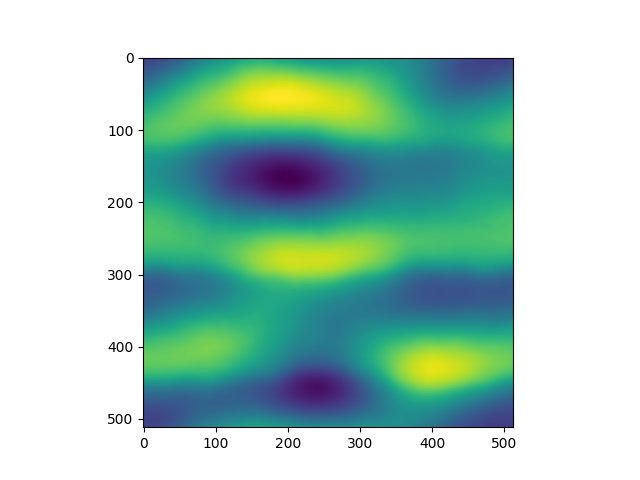

In [6]:


# Number of simulation
n = 70#70#901#70#6190#65

# Choose between 'local' or 'dahu' or 'dahu_downsized'
where = 'dahu'

# Reading the netcdf file
if where == 'local':
    if n < 10:
        simu_name = 'outdir_000' + str(n)
    elif n < 100 and n >= 10:
        simu_name = 'outdir_00' + str(n)
    Path = '/home/massoale/Simu_Test/qgw-main/src/' + simu_name + '/'
elif where == 'dahu':
    simu_name = 'dahu_' + str(n)
    Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'

elif where == 'dahu_downsized':
    simu_name = 'dahu_' + str(n)
    Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_downsized/'
    Path_bis = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'

else:
    print('Error: where not recognized')
    sys.exit()

print('la simulation chargée est: ' + simu_name)
print("depuis: " + where)

filenames = ['/vars.nc']

# Open the dataset using xarray
dataset = xr.open_dataset(Path + filenames[0],chunks={'time': 10})


# Load variables in chunks
t = dataset['time'].data
x = dataset['x'].data
y = dataset['y'].data
psi = dataset['psi'].isel( level=0).data
q = dataset['q'].isel(level=0).data
print("shape of psi :",np.shape(psi))


# Lecture des paramètres :
if where == 'dahu_downsized':
    param = io.read_params(Path_bis)
    nx = 160
    ny = 160
    param['NX'] = nx
    param['NY'] = ny
else:
    param = io.read_params(Path)
    nx = int(param['NX'])
    ny = int(param['NY'])

f0 = param['f0']
beta = param['beta']
hEkb = param['hEkb']
dh = param['dh'][0]
Lx = param['Lx']
k_f = param['k_f']
sigma_f = param['sigma_f']
bc_fac = param['bc_fac']
nu_hyper = param['nu_hyper']
n_hyper = param['n_hyper']
dt_out = param['dt_out']
print(param)
plt.figure()
plt.imshow(psi[-2, :, :])



In [7]:

tim_sel=np.arange(900,len(t),1)
psi_data = psi[tim_sel, :, :]
q_data = q[tim_sel, :, :]

dx=x[-1]/x.shape[0]
dy=y[-1]/y.shape[0]

Lx=x[-1] #Lengh of the domain
Ly=y[-1] #Width of the domain

#Calculating the energy
energy_totale=op.calc_en(psi_data, q_data,dx,bc_fac=bc_fac)/Lx**2


enstro=op.calc_lap(psi_data,dx,bc_fac=bc_fac)**2/2
print(np.shape(enstro))
enstro_mean=np.mean(enstro,axis=(1,2))
#Calculating the total enstrophy for each snapshots
enstro_tot=np.sum(enstro,axis=(1,2))


dx=x[-1]/x.shape[0]
r=f0*hEkb/(dh*2)


#energy injectée :
energy_inj=np.zeros_like(energy_totale)
energy_inj[:]=sigma_f**2
energy_diss=-2*energy_totale*r
#enstro_diss=-2*nu_hyper*enstro_mean

#Calculating the enerrgy dissipated by hyper-viscosity
lap_vorticity=op.calc_lap(q_data,dx,bc_fac=bc_fac)

if n_hyper==6:
    #palenstro_tot=np.sum(lap_vorticity**2,axis=(1,2))/Lx**2
    palenstro_tot=np.mean(lap_vorticity**2,axis=(1,2))
    enstro_diss=-nu_hyper*palenstro_tot 

#Dans le cas ou l'hyper visocisté est égale à 4:
elif n_hyper==4:    

    enstro_diss=nu_hyper*np.mean(lap_vorticity*q_data,axis=(1,2))

mean_enstro_diss=float(np.mean(enstro_diss[:]))
mean_energy_diss=float(np.mean(energy_diss[:]))
mean_energy_inj=float(np.mean(energy_inj[:]))

#computing the error of the energy dissipation
print("Error =",round(-mean_energy_diss-mean_enstro_diss-mean_energy_inj,7)/mean_energy_inj*100,'%')


ratioE=mean_energy_diss/mean_energy_inj*100
print("Energy_diss_drag/Energy_injected",-round(ratioE,3),'%')


N= 512 Nt= 704
(704, 512, 512)
(704, 512, 512)
N= 512 Nt= 704
(704, 512, 512)
Error = -12.49999861047415 %
Energy_diss_drag/Energy_injected 81.441 %


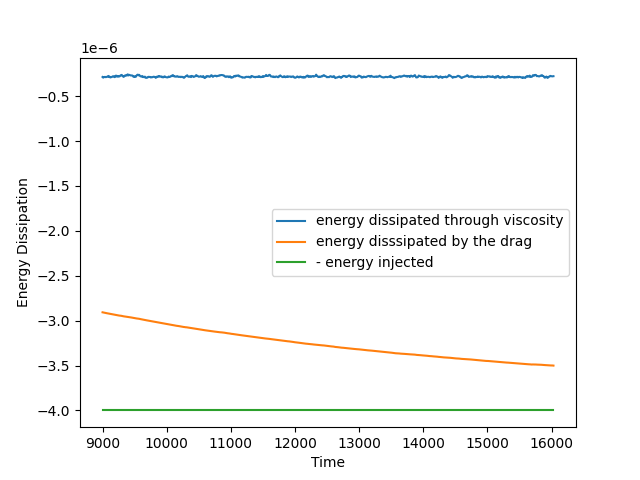

In [8]:

plt.figure()

plt.plot(t[tim_sel],enstro_diss,label='energy dissipated through viscosity')
plt.plot(t[tim_sel],energy_diss,label='energy disssipated by the drag')
plt.plot(t[tim_sel],-energy_inj,label='- energy injected')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Energy Dissipation')
#plt.title('Evolution of Energy of the simu '+str(simu_name))
#plt.savefig('./figures/Energy_Dissipation_'+str(simu_name)+'.png')
plt.show()


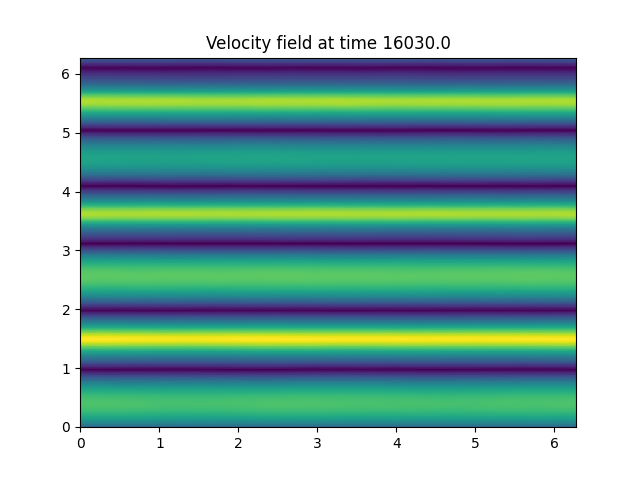

In [9]:
#Plotting the mean velocity field

time_start =1400

psi_data = psi[-time_start:, :, :]
dx=x[-1]/x.shape[0]
dy=y[-1]/y.shape[0]

Lx=x[-1] #Lengh of the domain
Ly=y[-1] #Width of the domain


X,Y=np.meshgrid(x,y)

u,v=op.calc_uv(psi_data,dx,bc_fac=bc_fac)
U=np.sqrt(np.mean(u,axis=0)**2+np.mean(v,axis=0)**2)
plt.figure()
plt.pcolormesh(X,Y,U)
plt.title('Velocity field at time '+str(t[-1]))
plt.savefig('./figures/Velocity/Velocity_field_'+str(simu_name)+'.png')
plt.show()


(512,)


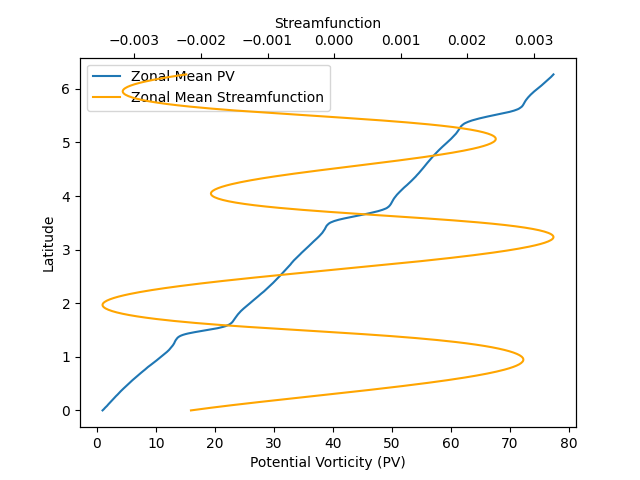

In [16]:
time_start =1300

tim_sel=np.arange(1,len(t),1)
psi_data = psi[tim_sel, :, :]
q_data = q[tim_sel, :, :]
print(np.shape(y))

q_zonal_mean = np.mean(q_data, axis=2)  # Averaging over the longitude axis
Psi_zonal_mean = np.mean(psi_data, axis=2)



epsilon=sigma_f**2
r=f0*hEkb/(2*dh)

k_rhines = beta**0.5/(epsilon/r)**(1/4)
Lrh=np.pi*2/k_rhines

# plt.figure()
# plt.plot((np.mean((q_zonal_mean[time_start:, :]),axis=0)+beta*y) / (Lrh*np.sqrt(epsilon/r)) ,y,label='Zonal Mean PV')
# plt.plot(np.mean(Psi_zonal_mean[time_start:, :] ,axis=0)/(beta*Lx),y, label='Zonal Mean Streamfunction')
# plt.ylabel('Latitude')
# plt.xlabel('PV / Streamfunction')
# plt.legend()

# plt.savefig('./figures/PV_stair/Zonal_mean_'+str(simu_name)+'.png')  
fig, ax = plt.subplots()

# First plot for Zonal Mean PV
line1, = ax.plot((np.mean((q_zonal_mean[time_start:, :]), axis=0) + beta * y) / (Lrh * np.sqrt(epsilon / r)), y, label='Zonal Mean PV')
ax.set_xlabel('Potential Vorticity (PV)')

# Second plot for Zonal Mean Streamfunction with a secondary x-axis
ax2 = ax.twiny()  # Use ax.twiny() instead of plt.gca().twiny() to link it directly
line2, = ax2.plot(np.mean(Psi_zonal_mean[time_start:, :], axis=0) / (beta * Lx), y, label='Zonal Mean Streamfunction', color='orange')
ax2.set_xlabel('Streamfunction')

# Set up the rest of the plot
ax.set_ylabel('Latitude')

# Combine the legends from both plots
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc='upper left')

# Save and show the figure
plt.savefig('./figures/PV_stair/Staircase_simu' + str(simu_name) + '.png')
plt.show()



In [95]:
print(y)

[0.         0.01227185 0.02454369 0.03681554 0.04908739 0.06135923
 0.07363108 0.08590292 0.09817477 0.11044662 0.12271846 0.1349903
 0.14726216 0.159534   0.17180584 0.1840777  0.19634955 0.20862138
 0.22089323 0.23316509 0.24543692 0.25770876 0.2699806  0.28225246
 0.2945243  0.30679616 0.319068   0.33133984 0.3436117  0.35588354
 0.3681554  0.38042724 0.3926991  0.4049709  0.41724277 0.42951462
 0.44178647 0.45405832 0.46633017 0.478602   0.49087384 0.5031457
 0.5154175  0.5276894  0.5399612  0.5522331  0.5645049  0.5767768
 0.5890486  0.60132045 0.6135923  0.62586415 0.638136   0.65040785
 0.6626797  0.67495155 0.6872234  0.69949526 0.7117671  0.72403896
 0.7363108  0.7485826  0.7608545  0.7731263  0.7853982  0.79767
 0.8099418  0.8222137  0.83448553 0.8467574  0.85902923 0.8713011
 0.88357294 0.89584476 0.90811664 0.92038846 0.93266034 0.94493216
 0.957204   0.96947587 0.9817477  0.99401957 1.0062914  1.0185633
 1.030835   1.0431069  1.0553788  1.0676507  1.0799224  1.0921943
 1.1

NameError: name 'psi_mean' is not defined

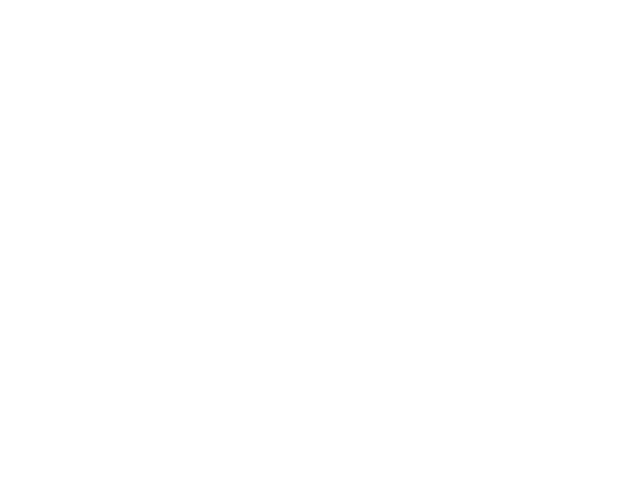

In [11]:
plt.figure()
plt.imshow(psi_mean,vmax=np.max(psi_mean))#+beta*Y)
plt.title('Mean Streamfunction of the simulation '+str(simu_name))
plt.savefig('./figures/jets/psi_mean_'+str(simu_name)+'.png')
plt.show()


In [26]:
#We plot the temporal mean streamfunction  and the temporal mean q
startt=0

#selecting an indice to avoid the boundary
indice_dep=int(0.03*nx)


q_mean = np.mean(q[startt:,0,indice_dep:-indice_dep,indice_dep:-indice_dep],axis=0)
psi_mean= np.mean(psi[startt:,0,indice_dep:-indice_dep,indice_dep:-indice_dep],axis=0)
X,Y=np.meshgrid(x[indice_dep:-indice_dep],y[indice_dep:-indice_dep])

plt.figure()
plt.scatter(psi_mean,q_mean+beta*Y)
plt.xlabel(r'$<\psi>$')
plt.ylabel('<q>')
plt.savefig('./figures/mean_psi_q_'+str(simu_name)+'.png')
plt.show()

print(q_mean.shape)



IndexError: Too many indices for array

In [67]:
tstart=0


#Computing the energy ratios
delta=Lx/nx

u,v=op.calc_uv(psi[tstart:,0,:,:],delta,bc_fac)
energy=0.5*(u**2+v**2)

#Mean energy
energy_tot=np.mean(energy,axis=0)

#Energy of the mean zonal flow
energy_zonal=0.5*(np.mean(u,axis=0)**2)

#Energy of the mean flow
energy_mean=0.5*(np.mean(np.sqrt(u**2+v**2),axis=0)**2)


ratioUzonUtot=energy_zonal/energy_tot
ratioUmeanUtot=energy_mean/energy_tot


plt.figure()
plt.imshow(ratioUzonUtot, cmap='jet')

plt.colorbar()
plt.title('Ratio of the energy of the zonal flow to the total energy')

plt.show()



IndexError: Too many indices for array

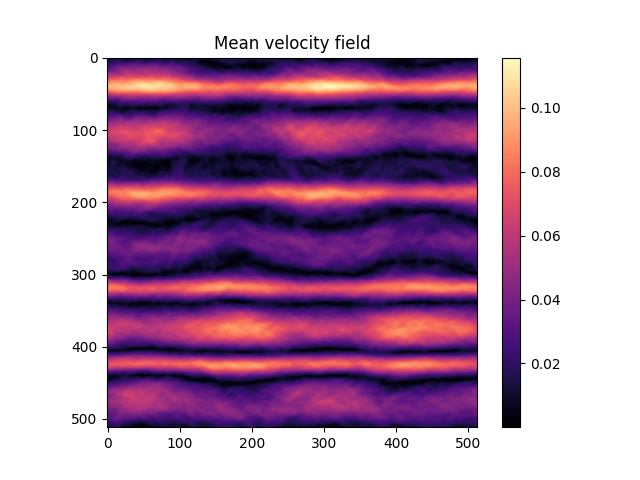

In [42]:
#plotting the average velocity field
u_mean=np.mean(u,axis=0)
v_mean=np.mean(v,axis=0)
U=np.sqrt(u_mean**2+v_mean**2)

plt.figure()
plt.imshow(U,cmap='magma')
plt.colorbar()
plt.title('Mean velocity field')
plt.show()

NameError: name 'ratioUmeanUtot' is not defined

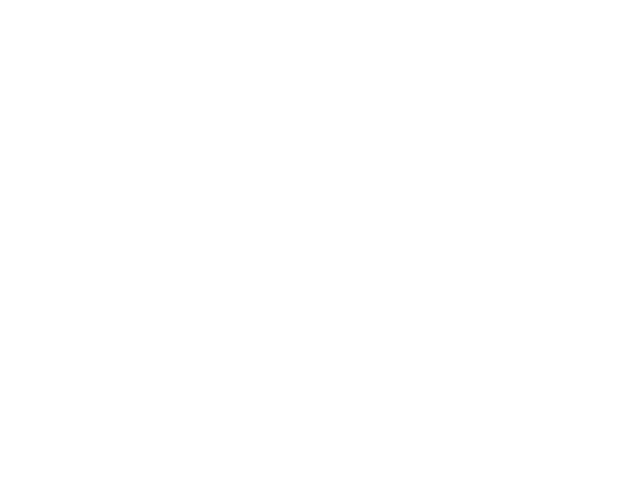

In [43]:
plt.figure()
plt.imshow(ratioUmeanUtot, cmap='jet',vmax=1)
plt.colorbar()
plt.title('Energy of the mean flow/Total Energy')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('./figures/jets/Energy_ratio_'+str(simu_name)+'.png')
plt.show()

# Measuring the size of the border jets

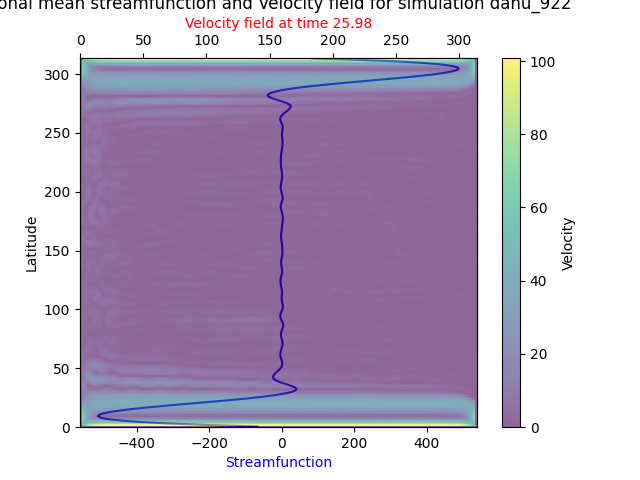

Zero crossings= [ 27.534954  37.352432  50.851463  55.7602    66.80486   74.16797
  81.53108   90.12137   97.48448  117.11943  129.39128  135.5272
 142.8903   156.38934  167.434    182.16022  190.7505   198.11362
 209.15828  216.5214   234.92915  257.0185   264.3816   276.65344
 285.24374 ]
Jet size= 9.203887939453125
Rhines length= 31.41592653589793
Domain Size= 313.46896


ValueError: Arrays chunk sizes are unknown: (nan,)

A possible solution: https://docs.dask.org/en/latest/array-chunks.html#unknown-chunks
Summary: to compute chunks sizes, use

   x.compute_chunk_sizes()  # for Dask Array `x`
   ddf.to_dask_array(lengths=True)  # for Dask DataFrame `ddf`

In [72]:
#plotting the zonnaly averaged stream function with respect to the latitude

psi_zonal_mean = np.mean(psi_data, axis=2)
psi_zonal_mean_temp = np.mean(psi_zonal_mean, axis=0)



# Create a figure and a single subplot
fig, ax1 = plt.subplots()

# First plot (Streamfunction vs Latitude)
ax1.plot(psi_zonal_mean_temp, y, color='b')
ax1.set_xlabel('Streamfunction', color='b')
ax1.set_ylabel('Latitude')
ax1.set_title('Zonal mean streamfunction and Velocity field for simulation ' + str(simu_name)) 

# Second plot (Velocity field) on the same figure with a second x-axis
ax2 = ax1.twiny()  # This creates a second x-axis sharing the same y-axis
c = ax2.pcolormesh(X, Y, U, shading='auto', alpha=0.6)
fig.colorbar(c, ax=ax2, orientation='vertical', label='Velocity')
ax2.set_xlabel('Velocity field at time ' + str(t[-1]), color='r')

# Adjust the position of the second x-axis for clarity
ax2.xaxis.set_label_position('top') 
ax2.xaxis.tick_top()

# Save the combined figure
plt.savefig('./figures/combined_plot_'+str(simu_name)+'.png')

# Show the figure
plt.show()



# plt.figure()
# plt.plot(psi_zonal_mean_temp,y)
# plt.xlabel('Streamfunction')
# plt.ylabel('Latitude')
# plt.title('Zonal mean streamfunction of the simulation '+str(simu_name)) 
# plt.savefig('./figures/jets/psi_zonal_mean_'+str(simu_name)+'.png')   
# plt.show()
# plt.figure()
# plt.pcolormesh(X,Y,U)
# plt.title('Velocity field at time '+str(t[-1]))
# plt.savefig('./figures/Velocity/Velocity_field_'+str(simu_name)+'.png')
# plt.show()

zero_crossings = np.where(np.diff(np.sign(psi_zonal_mean_temp)))[0] # Find the zero crossings
print("Zero crossings=",y[zero_crossings])
jet_size=(y[zero_crossings][1]-y[zero_crossings][0]+y[zero_crossings][-1]-y[zero_crossings][-2])/2
print("Jet size=",jet_size) 

#Me Compare witrh the Rhines lengh
epsilon=sigma_f**2
print("Rhines length=",np.pi*2/(beta**0.5/(epsilon/r)**(1/4)))
print("Domain Size=",Lx)    
indices=np.arange(zero_crossings[0],zero_crossings[1]+1,1)
plt.figure()
plt.imshow(psi_zonal_mean[:,indices],cmap='jet')
plt.show()

plt.figure()
plt.plot(psi_zonal_mean_temp[indices],y[indices])
plt.xlabel('Streamfunction')
plt.ylabel('Latitude')
plt.title('Zonal mean streamfunction of the simulation '+str(simu_name)) 
plt.savefig('./figures/jets/psi_zonal_mean_'+str(simu_name)+'.png')   
plt.show()

(1200, 256, 256)


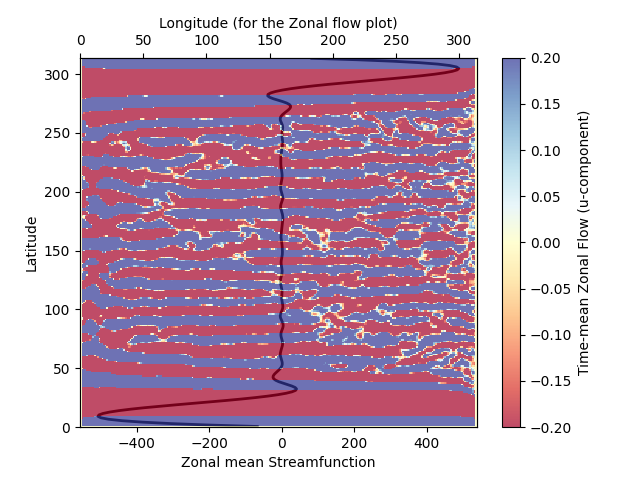

In [74]:
import matplotlib.colors as mcolors
print(np.shape(u))

# Create a custom normalization centered at 0
norm = mcolors.TwoSlopeNorm(vmin=np.min(u), vcenter=0, vmax=np.max(u))
# Create a figure and a single subplot
fig, ax1 = plt.subplots()

# First plot (Streamfunction vs Latitude)
ax1.plot(psi_zonal_mean_temp, y, color='k', linewidth=2, linestyle='-')
ax1.set_xlabel('Zonal mean Streamfunction', color='k')
ax1.set_ylabel('Latitude')
#ax1.set_title('Zonal mean streamfunction and Velocity field for simulation ' + str(simu_name)) 


# Plot the velocity direction (quiver plot)
step = 4  # Adjust this value to control the density of the arrows
X_quiver = X[::step, ::step]
Y_quiver = Y[::step, ::step]
u_quiver = u[:,::step, ::step]
v_quiver = v[:,::step, ::step]

u_mean=np.mean(u,axis=0)
ax2 = ax1.twiny()  # This creates a second x-axis sharing the same y-axis
c = ax2.pcolormesh(X, Y, u_mean,vmin=-0.2,vmax=0.2, cmap='RdYlBu', shading='auto',alpha=0.7)#.quiver(X_quiver, Y_quiver, np.mean(u_quiver,axis=0), np.mean(v_quiver,axis=0), color='black',scale=50) coolwarm
ax2.set_xlabel('Longitude (for the Zonal flow plot)')
ax2.set_ylabel('Latitude')
#ax2.set_title('Zonal flow intensity ' + str(simu_name))
cbar2 = fig.colorbar(c, ax=ax2, orientation='vertical', label='Time-mean Zonal Flow (u-component)')

# Save the combined figure
plt.savefig('./figures/jets/combined_plot_stream_u'+str(simu_name)+'.png')

# Show the figure
plt.show()


In [12]:
#finding the indices where psi is above 30% of the maximum value
psi_max=np.max(psi_zonal_mean_temp)

indices=np.where(psi_zonal_mean_temp>0.2*psi_max)


#Finding the lattitude of psi at the extremity of the jet
y_max=y[indices[0]]


#We plot the temporal mean streamfunction  and the temporal mean q
startt=0

#selecting an indice to avoid the boundary
indice_dep=int(0.03*nx)

#Jet area.
X_jet,Y_jet=np.meshgrid(x[indice_dep:-indice_dep],y[indices[0]])
psi_jet=psi_zonal_mean_temp[indices]
print(y[indices[0]].shape)

q_mean_jet = np.mean(q[startt:,0,indices[0],indice_dep:-indice_dep],axis=0)
psi_mean_jet= np.mean(psi[startt:,0,indices[0],indice_dep:-indice_dep],axis=0)
pol=np.polyfit(psi_mean_jet.flatten(),q_mean_jet.flatten()+beta*Y_jet.flatten(),1)


plt.figure()
plt.scatter(psi_mean_jet,q_mean_jet+beta*Y_jet)
plt.plot(psi_mean_jet.flatten(),pol[0]*psi_mean_jet.flatten()+pol[1],label='Linear fitting',color='red')
plt.xlabel(r'$<\psi>$')
plt.ylabel('<q>')
plt.legend()
plt.savefig('./figures/jets/linearfit_jet'+str(simu_name)+'.png')
plt.show()

print(q_mean.shape)
plt.figure()
plt.contourf(X,Y,psi_mean,levels=[-0.008,0.008],cmap='coolwarm')
plt.contourf(X_jet,Y_jet,psi_mean_jet,cmap='coolwarm')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Region of the domain of the regression of '+r'$<\psi>$')
plt.savefig('./figures/jets/psi_mean_jet_'+str(simu_name)+'.png')
plt.show()

X_tot,Y_tot=np.meshgrid(x,y)
plt.figure()
plt.contourf(X_tot,Y_tot,np.mean(psi[:,0,:,:],axis=0),cmap='coolwarm')
#plt.contourf(X_jet,Y_jet,psi_mean_jet,cmap='coolwarm')
cb=plt.colorbar()
cb.set_label('Streamfunction')
plt.xlabel('x')
plt.ylabel('y')
#plt.title('Region of the domain of the regression of '+r'$<\psi>$')
plt.savefig('./figures/jets/psi_mean'+str(simu_name)+'.png')
plt.show()


NameError: name 'psi_zonal_mean_temp' is not defined

In [ ]:
# u,v=op.calc_uv(psi_data,dx,bc_fac=bc_fac)

# plt.figure()
# plt.imshow(np.mean(u[:,:,:]**2+v**2,axis=0))
# plt.colorbar()